## Imports

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [91]:
# Set the device to GPU if availible or to cpu by default
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Load Data

In [92]:
data = pd.read_csv('/content/GOOG.csv') # Read data

In [93]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
...,...,...,...,...,...,...,...
4853,2023-11-29,138.985001,139.669998,136.294998,136.399994,136.399994,21014700
4854,2023-11-30,136.399994,136.960007,132.789993,133.919998,133.919998,29913500
4855,2023-12-01,133.320007,133.500000,132.151993,133.320007,133.320007,24258400
4856,2023-12-04,131.294006,131.449997,129.399994,130.630005,130.630005,24117100


In [94]:
data = data[['Date', 'Close']]

In [95]:
data

,Date,Close
0,2004-08-19,2.499133
1,2004-08-20,2.697639
2,2004-08-23,2.724787
3,2004-08-24,2.611960
4,2004-08-25,2.640104
...,...,...
4853,2023-11-29,136.399994
4854,2023-11-30,133.919998
4855,2023-12-01,133.320007
4856,2023-12-04,130.630005


## Data preperation

<ipython-input-96-15d0ea3caca6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date']) # convert the Date column from string to Date Time object


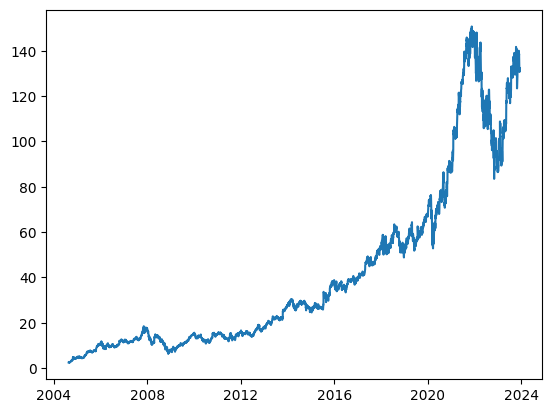

In [96]:
data['Date'] = pd.to_datetime(data['Date']) # convert the Date column from string to Date Time object

plt.plot(data['Date'], data['Close']) # Plot the values

In [97]:
def prepare_data(df, n):
  df = deepcopy(df) # Create a deep copy

  df.set_index('Date', inplace=True) # Set the index as the date column

  for i in range(1, n+1):
    df[f'Close(t-{i})'] = df['Close'].shift(i, axis=0) # Shift the data by n days for closing price

  df.dropna(inplace=True)

  return df

In [98]:
lookback = 7 # value for # of days to lookback
shifted_data = prepare_data(data, lookback)

In [99]:
shifted_data

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2004-08-30,2.540727,2.643840,2.687676,2.640104,2.611960,2.724787,2.697639,2.499133
2004-08-31,2.549693,2.540727,2.643840,2.687676,2.640104,2.611960,2.724787,2.697639
2004-09-01,2.496891,2.549693,2.540727,2.643840,2.687676,2.640104,2.611960,2.724787
2004-09-02,2.528273,2.496891,2.549693,2.540727,2.643840,2.687676,2.640104,2.611960
2004-09-03,2.490913,2.528273,2.496891,2.549693,2.540727,2.643840,2.687676,2.640104
...,...,...,...,...,...,...,...,...
2023-11-29,136.399994,138.619995,138.050003,138.220001,140.020004,138.619995,137.919998,136.940002
2023-11-30,133.919998,136.399994,138.619995,138.050003,138.220001,140.020004,138.619995,137.919998
2023-12-01,133.320007,133.919998,136.399994,138.619995,138.050003,138.220001,140.020004,138.619995


In [100]:
# Convert the dataframe to a numpy array
shifted_data_np = shifted_data.to_numpy()

In [101]:
# Scale data using MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
shifted_data_np = scaler.fit_transform(shifted_data_np)

shifted_data_np

array([[-0.99932783, -0.99793646, -0.99734495, ..., -0.99684419,
        -0.99721052, -0.99988908],
       [-0.99920684, -0.99932783, -0.99793646, ..., -0.99836664,
        -0.99684419, -0.99721052],
       [-0.99991934, -0.99920684, -0.99932783, ..., -0.99798687,
        -0.99836664, -0.99684419],
       ...,
       [ 0.76535937,  0.77345542,  0.80691957, ...,  0.83147807,
         0.85576664,  0.83687544],
       [ 0.72906147,  0.76535937,  0.77345542, ...,  0.82918418,
         0.83147807,  0.85576664],
       [ 0.75281018,  0.72906147,  0.76535937, ...,  0.83687544,
         0.82918418,  0.83147807]])

In [102]:
# Features and labels
X = shifted_data_np[:,1:]
y = shifted_data_np[:,0]

X.shape, y.shape

((4851, 7), (4851,))

In [103]:
# Flip the data so that it goes from t-7,...t-1 i.e oldest to newest
X = deepcopy(np.flip(X, axis=1))
X

array([[-0.99988908, -0.99721052, -0.99684419, ..., -0.99798687,
        -0.99734495, -0.99793646],
       [-0.99721052, -0.99684419, -0.99836664, ..., -0.99734495,
        -0.99793646, -0.99932783],
       [-0.99684419, -0.99836664, -0.99798687, ..., -0.99793646,
        -0.99932783, -0.99920684],
       ...,
       [ 0.83687544,  0.85576664,  0.83147807, ...,  0.83687544,
         0.80691957,  0.77345542],
       [ 0.85576664,  0.83147807,  0.82918418, ...,  0.80691957,
         0.77345542,  0.76535937],
       [ 0.83147807,  0.82918418,  0.83687544, ...,  0.77345542,
         0.76535937,  0.72906147]])

In [104]:
# Split index
split_index = int(len(X)*0.95) # 95% of the data for training and 5% for testing
split_index

4608

In [105]:
# Splitting into training and testing data

# Train
X_train = X[:split_index]
y_train = y[:split_index]

# Test
X_test = X[split_index:]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4608, 7), (243, 7), (4608,), (243,))

In [106]:
# Adding an extradimension at the end for pytorch LSTMs

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4608, 7, 1), (243, 7, 1), (4608, 1), (243, 1))

In [107]:
# Converting numpy arrays into tensors

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()


y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4608, 7, 1]),
 torch.Size([243, 7, 1]),
 torch.Size([4608, 1]),
 torch.Size([243, 1]))

In [108]:
# Make a custom dataset class

class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [109]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [110]:
# Implementing DataLoader

batch_size = 12

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [111]:
len(train_loader), len(test_loader)

(384, 21)

In [112]:
it = iter(train_loader)
x, y = next(it)
print(x.shape, y.shape)

torch.Size([12, 7, 1]) torch.Size([12, 1])


## Model - LSTM

In [149]:
# Set seed
torch.manual_seed(42)

In [150]:
# Defining the model

class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers=1):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                        batch_first=True)

    self.fc1 = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc1(out[:, -1, :])

    return out

In [151]:
# Model instantiation
model = LSTM(1, 4, 1).to(device) # input_size = 1 (close value), hidden_size = 5, num_stacked_layers = 1

In [152]:
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc1): Linear(in_features=4, out_features=1, bias=True)
)

In [153]:
# Loss, optimizer, etc
loss_type = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [154]:
# Training and testing
epochs = 100
start_timer = time.time()
training_loss = []
flag = False

for epoch in range(epochs):

  # Training
  model.train(True)
  running_loss = 0.0
  if (epoch+1)%20==0:
    print(f"Epoch:{epoch+1}/{epochs}")
    flag = True

  for i, batch in enumerate(train_loader):
    inputs, labels = batch[0].to(device), batch[1].to(device) # Convert the input to 'device'(gpu or cpu) type

    output = model(inputs) # Make predictions

    loss = loss_type(output, labels) # Calculate the loss
    running_loss += loss.item() # Update running loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1)%100 == 0 and flag == True:
      avg_loss = running_loss / 100
      print(f"\tBatch: {i+1}, Loss:{avg_loss}")
      running_loss = 0.0
  flag = False
  training_loss.append(running_loss)
  # validate_one_epoch()

end_timer = time.time()
print()
print(f"Took {(end_timer-start_timer)/60} minutes to train")

Epoch:20/100
	Batch: 100, Loss:0.0003149128664881573
	Batch: 200, Loss:0.00026947648353598197
	Batch: 300, Loss:0.0003107909514437779
Epoch:40/100
	Batch: 100, Loss:0.00027366327278286915
	Batch: 200, Loss:0.00021615358264170936
	Batch: 300, Loss:0.00019232803660088394
Epoch:60/100
	Batch: 100, Loss:0.00020019007579321623
	Batch: 200, Loss:0.00021016051538936154
	Batch: 300, Loss:0.00021370172402384924
Epoch:80/100
	Batch: 100, Loss:0.00016472701367547415
	Batch: 200, Loss:0.0001999952213100187
	Batch: 300, Loss:0.00016562041935685556
Epoch:100/100
	Batch: 100, Loss:0.00016231029496339034
	Batch: 200, Loss:0.00019223077593778727
	Batch: 300, Loss:0.00017495234336365684

Took 1.4567198793093363 minutes to train


In [155]:
# Testing
test_loss = []
total_samples = 0
correct = 0

with torch.no_grad():
  for epoch in range(epochs):
    model.train(False)
    running_loss = 0.0
    if (epoch+1)%20==0:
      print(f"Epoch:{epoch+1}/{epochs}")
      flag = True

    for i, batch in enumerate(test_loader):
      inputs, labels = batch[0].to(device), batch[1].to(device)

      output = model(inputs) # Make predictions
      correct += (output == labels).sum()
      total_samples += labels.size(0)

      loss = loss_type(output, labels) # Calculate the loss
      running_loss += loss.item()
    test_loss.append(running_loss)
    avg_loss_across_batches = running_loss / len(test_loader)

    if flag:
      print(f"Validation Loss: {avg_loss_across_batches}")
      print("*"*100)
      flag = False

Epoch:20/100
Validation Loss: 0.000904176306600372
****************************************************************************************************
Epoch:40/100
Validation Loss: 0.000904176306600372
****************************************************************************************************
Epoch:60/100
Validation Loss: 0.000904176306600372
****************************************************************************************************
Epoch:80/100
Validation Loss: 0.000904176306600372
****************************************************************************************************
Epoch:100/100
Validation Loss: 0.000904176306600372
****************************************************************************************************


## Training and testing error

Text(0.5, 1.0, 'Training vs Testing Loss')

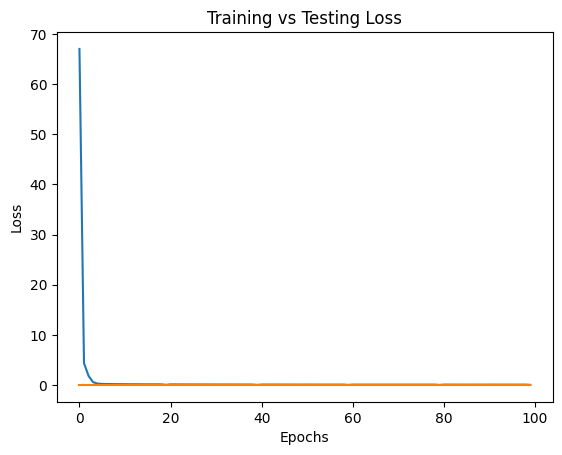

In [156]:
plt.plot(range(epochs), training_loss)
plt.plot(range(epochs), test_loss)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Training vs Testing Loss")

## Results

#### Train data

In [157]:
# Calculate the predictions

with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').numpy()

In [158]:
# Perform inverse transform to scale back the values from (-1, 1) range to their actual values

train_predictions = predicted.flatten() # Flatten the pred values to make sure theres 1 dim

dum = np.zeros((X_train.shape[0], lookback+1)) # Make a dummy matrix with the same dimensions as X_train
dum[:, 0] = train_predictions # Assign the first column the predicted values
dum = scaler.inverse_transform(dum) # Perform the inverse transform to scale back the values

train_predictions = deepcopy(dum[:, 0]) # Get a deepcopy of the scaled predictions
train_predictions

array([ 2.76925675,  2.716294  ,  2.69219794, ..., 93.86643236,
       96.06667224, 95.68225944])

In [159]:
# Perform the same operation for y_train

dum = np.zeros((X_train.shape[0], lookback+1))
dum[:, 0] = y_train.flatten()
dum = scaler.inverse_transform(dum)

new_y_train = deepcopy(dum[:, 0])
new_y_train

array([ 2.54072625,  2.54969326,  2.49688953, ..., 95.84999763,
       95.30999848, 91.19999662])

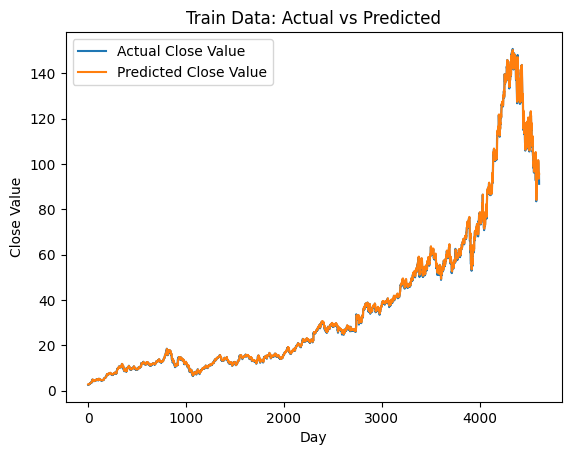

In [160]:
# Plot the values
plt.plot(new_y_train, label='Actual Close Value')
plt.plot(train_predictions, label='Predicted Close Value')
plt.xlabel('Day')
plt.ylabel('Close Value')
plt.title('Train Data: Actual vs Predicted')
plt.legend()
plt.show()

#### Test data

In [161]:
# Calculate predictions on the test set
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten() # using detach is an alternative to torch.no_grad()
test_predictions.shape

(243,)

In [162]:
# Perform inverse transform for predictions

dum = np.zeros((X_test.shape[0], lookback+1))
dum[:, 0] = test_predictions
dum = scaler.inverse_transform(dum)

test_predictions = deepcopy(dum[:, 0])
test_predictions.shape

(243,)

In [163]:
# Perform the same operation for y_test

dum = np.zeros((X_test.shape[0], lookback+1))
dum[:, 0] = y_test.flatten()
dum = scaler.inverse_transform(dum)

new_y_test = deepcopy(dum[:, 0])
new_y_test.shape

(243,)

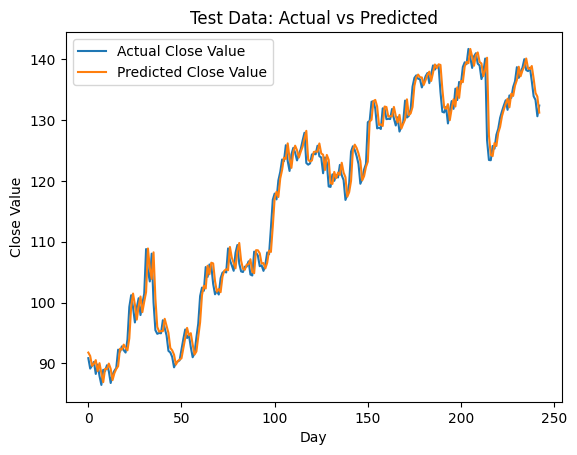

In [164]:
plt.plot(new_y_test, label='Actual Close Value')
plt.plot(test_predictions, label='Predicted Close Value')
plt.xlabel('Day')
plt.ylabel('Close Value')
plt.title('Test Data: Actual vs Predicted')
plt.legend()
plt.show()

In [173]:
# Calculating the mean-squared-error and the r2 score
print("Mean Squared Error: {0:.3f}".format(mean_squared_error(new_y_test, test_predictions)))
print("R2 Score: {0:.3f}".format(r2_score(new_y_test, test_predictions)))

Mean Squared Error: 4.988
R2 Score: 0.982
